# Pre processing for CNN

In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

In [6]:
print("Loading CSV file {}".format('UrbanSound8K.csv'))

# Load metadata as a Pandas dataframe
metadata = pd.read_csv('urbansound8k/metadata/UrbanSound8K.csv')

# Examine dataframe's head
metadata.head()

Loading CSV file UrbanSound8K.csv


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## Feature extraction

In [23]:
row=metadata.sample(1)
file_path = 'urbansound8k/audio' + '/fold'+ str(row.iloc[0,5]) +'/' + str(row.iloc[0,0])
y, sr = librosa.load(file_path)
normalized_y = librosa.util.normalize(y)

### Mel-Frequency Cepstral Coefficients (MFCCs)


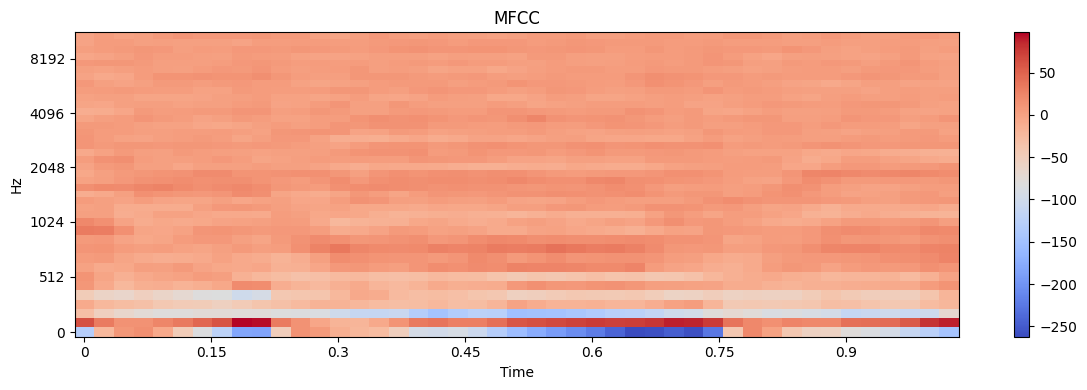

In [24]:
# Generate MFCC coefficients
mfcc = librosa.feature.mfcc(y=normalized_y, sr=sr, n_mfcc=40)

# Plot spectrogram from STFT
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

### Spectrograms


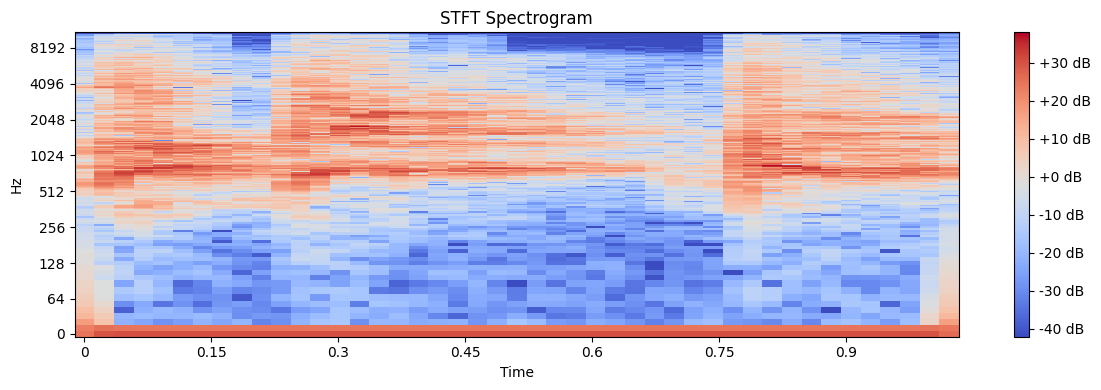

In [25]:
# Compute STFT
stft = librosa.core.stft(normalized_y, n_fft=2048, hop_length=512)

# Convert sound intensity to log amplitude:
stft_db = librosa.amplitude_to_db(abs(stft))


# Plot spectrogram from STFT
plt.figure(figsize=(12, 4))
librosa.display.specshow(stft_db, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT Spectrogram')
plt.tight_layout()
plt.show()


## Data Augmentation

Data augmentation were applied to the audio data using the following techniques:

- **Adding White Noise**: Random noise was added to the audio signal to simulate different recording conditions.
- **Pitch Shifting**: The pitch of the audio signal was randomly shifted up or down to create variations in the audio.
- **Time Stretching**: The audio signal was stretched or compressed in time to create variations in the speed of the audio.

By augmenting the data, we aim to improve the model's ability to generalize to new, unseen data.

In [26]:
def augment_audio(y, sr):
    # Adding white noise
    noise_level = np.random.uniform(0.01, 0.05)  # Random noise level
    noise = np.random.normal(0, 1, len(y))
    y_noisy = y + noise_level * noise

    # Pitch shifting
    n_steps = np.random.uniform(-4, 4)  # Random pitch shift between -4 and +4 semitones
    y_pitch_shift = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

    # Time stretching
    stretch_rate = np.random.uniform(0.8, 1.25)  # Random stretch rate between 0.8x and 1.25x
    y_time_stretched = librosa.effects.time_stretch(y, rate=stretch_rate)
    
    return y_pitch_shift, y_time_stretched, y_noisy

In [27]:
def get_features(y,sr, n_mfcc):
    y = librosa.util.normalize(y) # Normalize audio data between -1 and 1
    
    features=[]

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    for i in range(1, 14):
        features.append(mfccs[i - 1])
        
    return features

In [28]:
def add_padding(features, mfcc_max_padding=174):
    padded = []

    # Add padding in both sides
    for i in range(len(features)):
        px = features[i]
        size = len(px[0])
        # Add padding if required
        if (size < mfcc_max_padding):
            xDiff = mfcc_max_padding - size
            xLeft = xDiff//2
            xRight = xDiff-xLeft
            px = np.pad(px, pad_width=((0,0), (xLeft, xRight)), mode='constant')
        
        padded.append(px)

    return padded

In [29]:
def envelope_moving_average(signal, window_size=100):
    envelope = np.convolve(np.abs(signal), np.ones(window_size)/window_size, mode='same')
    return envelope

### Extracting Mel-frequency cepstral coefficients (MFCCs) - 2D

In [36]:
frames_max = 0
total_samples = len(metadata)
n_mfcc = 13

# Initialize X_folds and y_folds as lists
X_folds = [[] for _ in range(10)]  # List of lists, each sublist corresponds to a fold's features
y_folds = [[] for _ in range(10)]

for index, row in metadata.iterrows():
    file_path = os.path.join(os.path.abspath('urbansound8k/audio'), 'fold' + str(row["fold"]), str(row["slice_file_name"]))
    fold_value = row['fold'] - 1
    class_id = row['classID']
    y, sr = librosa.load(file_path)
    #y_pitch, y_noisy, y_time = augment_audio(y, sr)
    
    # Extract MFCCs (do not add padding)
    features = get_features(y, sr, n_mfcc)
    #features_noisy = get_features(y_noisy, sr, n_mfcc)
    #features_pitch = get_features(y_pitch, sr, n_mfcc)
    #features_time = get_features(y_time, sr, n_mfcc)

    # Save current frame count
    num_frames = features[-1].shape[0]
    
    X_folds[fold_value].append(features)
    #X_folds[fold_value].append(features_noisy)
    #X_folds[fold_value].append(features_pitch)
    #X_folds[fold_value].append(features_time)
    y_folds[fold_value].append(class_id)
    #y_folds[fold_value].append(class_id)
    #y_folds[fold_value].append(class_id)
    #y_folds[fold_value].append(class_id)

    # Update frames maximum
    if (num_frames > frames_max):
        frames_max = num_frames
    
print("Finished: {}/{}".format(index+1, total_samples))

/home/jp/.env/py311/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(


KeyboardInterrupt: 

In [31]:
X_folds_padded = [[] for _ in range(10)]
for i in range(len(X_folds)):
    X_folds_padded[i]=add_padding(X_folds[i])

In [ ]:
for i in range(10):
    np.save(f'processed_features/mfccs/fold_{i + 1}_13mfcc_features.npy', X_folds_padded[i])
    np.save(f'processed_features/mfccs/fold_{i + 1}_13mfcc_labels.npy', y_folds[i])

print("X_folds and y_folds have been saved successfully.")

X_folds and y_folds have been saved successfully.


### Extracting Mel Spectograms - 2D

In [37]:
metadata = pd.read_csv('urbansound8k/metadata/UrbanSound8K.csv')
frames_max = 0
total_samples = len(metadata)

# Initialize X_folds and y_folds as lists
X_folds = [[] for _ in range(10)]  # List of lists, each sublist corresponds to a fold's features
y_folds = [[] for _ in range(10)]

for index, row in metadata.iterrows():
    file_path = os.path.join(os.path.abspath('urbansound8k/audio'), 'fold' + str(row["fold"]), str(row["slice_file_name"]))
    fold_value = row['fold'] - 1
    class_id = row['classID']
    y, sr = librosa.load(file_path)
    n_fft = 2048               # Number of FFT components
    hop_length = 512           # Number of samples between successive frames
    n_mels = 80              # Number of Mel bands
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    features = librosa.power_to_db(mel_spectrogram, ref=np.max)
    X_folds[fold_value].append(features)
    y_folds[fold_value].append(class_id)

    
print("Finished: {}/{}".format(index+1, total_samples))

/home/jp/.env/py311/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/home/jp/.env/py311/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/home/jp/.env/py311/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


Finished: 8732/8732


In [38]:
X_folds_padded = [[] for _ in range(10)]
for i in range(len(X_folds)):
    X_folds_padded[i]=add_padding(X_folds[i])

In [ ]:
for i in range(10):
    np.save(f'processed_features/mel_spec_2d/fold{i + 1}mel80_features.npy', X_folds_padded[i])
    np.save(f'processed_features/mel_spec_2d/fold{i + 1}mel80_labels.npy', y_folds[i])

print("X_folds and y_folds have been saved successfully.")

X_folds and y_folds have been saved successfully.
